# Captcha Recognition

Пошарим по директории:

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-captcha-recognition/sample_submission.csv
/kaggle/input/sf-captcha-recognition/data/images_unlabeled.npy
/kaggle/input/sf-captcha-recognition/data/images.npy
/kaggle/input/sf-captcha-recognition/data/labels.npy
/kaggle/input/sf-captcha-recognition/data/images_sub.npy


# Description

Нам предлагается задача из области компьютерного зрения – распознавание букв английского алфавита на искаженных и зашумленных изображениях, используемых для стандартных тестов пользователя. Примеры:

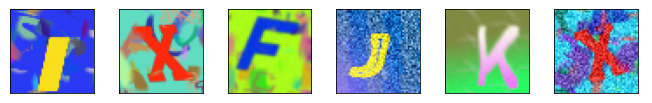

Данные для обучения содержатся в двух файлах: images.npy и labels.npy. Это формат numpy-массивов.

Всего доступно 20 тысяч размеченных изображений размером 48x48 с 3 цветовых каналами (RGB), поэтому массив images имеет размер (20000, 48, 48, 3). В массиве labels содержатся ответы к тренировочному набору изображений. В английском алфавите 26 букв: 0-й класс соответствует букве А и так далее по алфавиту, 25-й класс - буква Z.

Наша задача - обучить нейронную сеть и с ее помощью предсказать метки классов для изображений из файла images_sub.npy, в нем 50 тысяч изображений.

sample_submission.csv не содержит полезных данных, а лишь описывает формат, в котором надо загрузить предсказания на сайт.

Метрика лидерборда - accuracy, то есть доля правильно распознанных изображений.

Captcha Recognition – это учебная задача, но она моделирует реальную. В реальных задачах разметка данных часто является трудоемким процессом, и как правило неразмеченных данных (то есть без ответов) доступно гораздо больше, чем размеченных. Поэтому авторы задачи решили сделать так же. В файле images_unlabeled.npy содержится еще 100 тысяч неразмеченных изображений. Существуют способы использовать для обучения их тоже, но это уже задача со звездочкой.

# Setup

Для удобства вынесем основные переменные.

In [4]:
EPOCHS               = 50
BATCH_SIZE           = 128
LR                   = 1e-3
VAL_SPLIT            = 0.2

NUM_CLASSES          = 26
IMG_SIZE             = 48
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [6]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.constraints as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [8]:
# Загрузка данных
images = np.load('/kaggle/input/sf-captcha-recognition/data/images.npy')
images_sub = np.load('/kaggle/input/sf-captcha-recognition/data/images_sub.npy')
labels = np.load('/kaggle/input/sf-captcha-recognition/data/labels.npy')

In [9]:
# Сэмплирование
x_train, x_valid, y_train, y_valid = train_test_split(
    images, labels, train_size=0.8, stratify = labels, random_state=42
)

In [10]:
print('Данные:')
print('Треннировочные:', x_train.shape, y_train.shape)
print('Валидационные: ', x_valid.shape, y_valid.shape)
print('Тестовые:      ', images_sub.shape)

Данные:
Треннировочные: (16000, 48, 48, 3) (16000,)
Валидационные:  (4000, 48, 48, 3) (4000,)
Тестовые:       (50000, 48, 48, 3)


In [11]:
import string

cifar10_classes = list(string.ascii_uppercase)
print(cifar10_classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


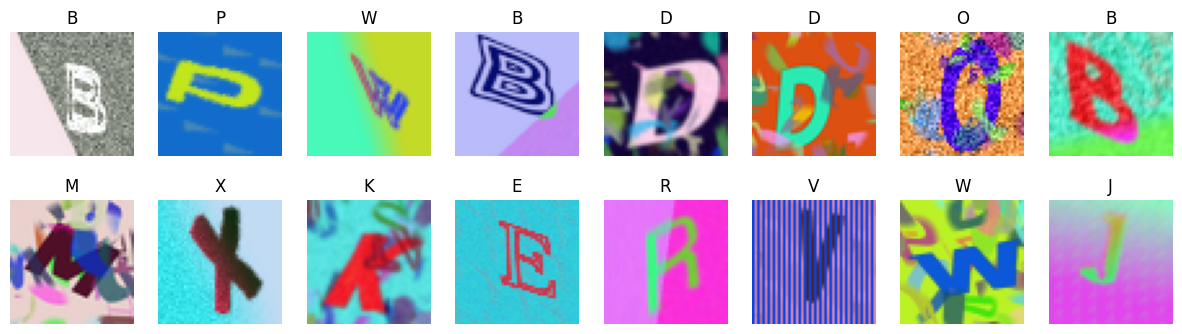

In [12]:
# Посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

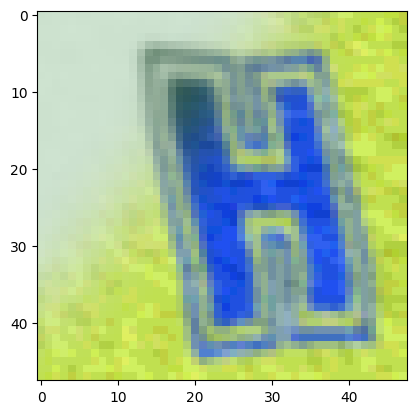

In [13]:
plt.imshow(x_train[42]);

# Готовим данные

Нормализуем картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [14]:
# Нормализация
x_train_norm = x_train.astype('float32') / 255 - 0.5
x_valid_norm = x_valid.astype('float32') / 255 - 0.5

# encoding
y_train_e = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid_e = keras.utils.to_categorical(y_valid, NUM_CLASSES)

y_train_e.shape

(16000, 26)

# Задаем *дефолтную* архитектуру сети

In [28]:
model = M.Sequential()
model.add(L.Input(shape=input_shape))
model.add(L.Conv2D(32, kernel_size=3, padding='same',activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(L.BatchNormalization())
model.add(L.Conv2D(32, kernel_size = 3, padding = 'same', strides = 2,  activation = 'relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(rate = 0.5))
model.add(L.Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(L.MaxPool2D(pool_size = 2, padding = 'same' ))
model.add(L.BatchNormalization())
model.add(L.Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(L.MaxPool2D(pool_size = 2, padding = 'same' ))
model.add(L.BatchNormalization())
model.add(L.Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(L.MaxPool2D(pool_size = 2, padding = 'same' ))
model.add(L.BatchNormalization())
model.add(L.Dropout(rate = 0.5))
model.add(L.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(L.MaxPool2D(pool_size = 2, padding = 'same' ))
model.add(L.BatchNormalization())
model.add(L.Flatten())
model.add(L.Dense(1024, activation='relu'))
model.add(L.Dropout(rate = 0.5))
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(NUM_CLASSES, activation = 'softmax'))

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,250,714 (4.77 MB)

 Trainable params: 1,249,882 (4.77 MB)

 Non-trainable params: 832 (3.25 KB)

In [30]:
K.clear_session()

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.fit(
    x_train_norm, y_train_e,
    batch_size=128,
    epochs=100,
    validation_data=(x_valid_norm, y_valid_e)
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.0439 - loss: 3.3737 - val_accuracy: 0.0353 - val_loss: 3.2710
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0588 - loss: 3.2009 - val_accuracy: 0.0377 - val_loss: 3.5707
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1178 - loss: 2.9659 - val_accuracy: 0.0532 - val_loss: 3.3174
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2640 - loss: 2.4261 - val_accuracy: 0.3632 - val_loss: 2.1120
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4665 - loss: 1.7255 - val_accuracy: 0.5913 - val_loss: 1.2685
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5782 - loss: 1.3414 - val_accuracy: 0.6977 - val_loss: 0.9481
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6495 - loss: 1.1064 - val_accuracy: 0.7423 - val_loss: 0.8093
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6967 - loss: 0.9445 -

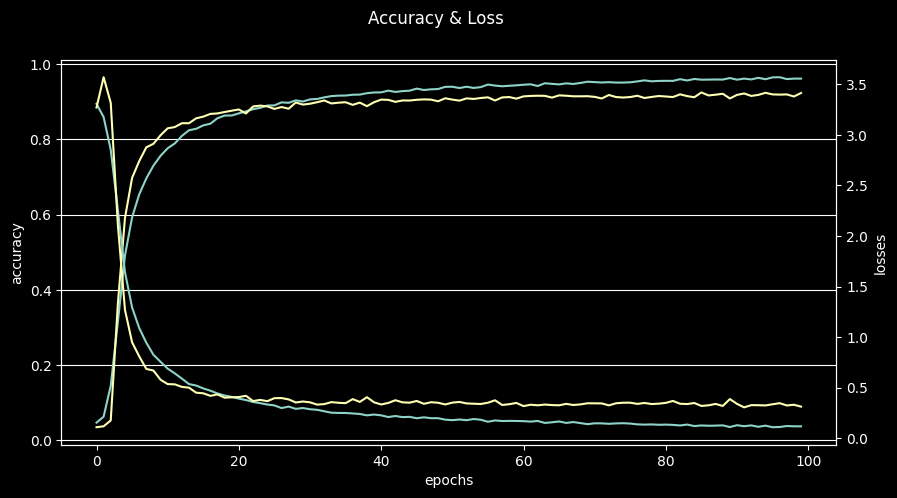

In [31]:
history = model.history
plt.style.use(['dark_background'])
_, ax1 = plt.subplots(sharex=True, figsize=(10, 5))
plt.suptitle('Accuracy & Loss')
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
plt.grid(axis='y')
ax2 = ax1.twinx()
ax2.plot(model.history.history['loss'])
ax2.plot(model.history.history['val_loss'])
ax2.set_ylabel('losses')
plt.show()

# Model

In [115]:
base_model = tf.keras.applications.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='max'
)
model=M.Sequential()
model.add(base_model)
model.add(L.Dense(128, activation='relu', kernel_constraint=C.MaxNorm(3)))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(NUM_CLASSES, activation='softmax'))

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [116]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ ?                      │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 6,513,184 (24.85 MB)

 Non-trainable params: 62,055 (242.41 KB)

# Тренируем модель

In [117]:
K.clear_session()

model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers.Adam(learning_rate=1e-3),
  metrics=['accuracy']
)

# checkpoint = ModelCheckpoint(
#     'best_model.keras', monitor = ['val_accuracy'],
#     verbose=1, mode='max'
# )
# earlystop = EarlyStopping(
#     monitor='val_accuracy', patience=5,
#     restore_best_weights=True
# )
# callbacks_list = [checkpoint, earlystop]

model.fit(
  x_train_norm, y_train_e,
  batch_size=128,
  epochs=50,
  validation_data=(x_valid_norm, y_valid_e),
  shuffle=False
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 146s 187ms/step - accuracy: 0.1548 - loss: 3.5073 - val_accuracy: 0.0397 - val_loss: 3.5182
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.6403 - loss: 1.1712 - val_accuracy: 0.0855 - val_loss: 3.2201
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8377 - loss: 0.5380 - val_accuracy: 0.3970 - val_loss: 2.0844
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9079 - loss: 0.3073 - val_accuracy: 0.6963 - val_loss: 1.1338
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9428 - loss: 0.1858 - val_accuracy: 0.8150 - val_loss: 0.6698
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9561 - loss: 0.1447 - val_accuracy: 0.8515 - val_loss: 0.6023
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9598 - loss: 0.1275 - val_accuracy: 0.8727 - val_loss: 0.5561
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9667 - loss: 0.1153 

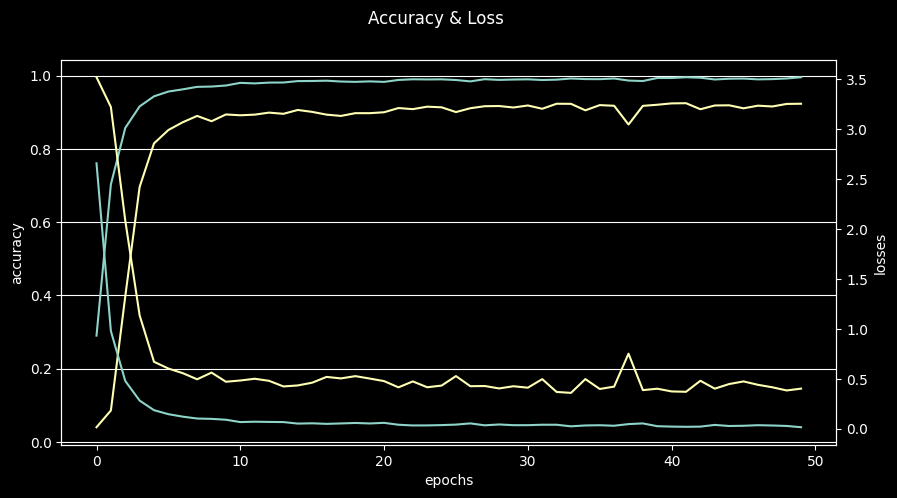

In [118]:
history = model.history
plt.style.use(['dark_background'])
_, ax1 = plt.subplots(sharex=True, figsize=(10, 5))
plt.suptitle('Accuracy & Loss')
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
plt.grid(axis='y')
ax2 = ax1.twinx()
ax2.plot(model.history.history['loss'])
ax2.plot(model.history.history['val_loss'])
ax2.set_ylabel('losses')
plt.show()

# Submit

In [125]:
import pandas as pd
submission = pd.read_csv('/kaggle/input/sf-captcha-recognition/sample_submission.csv')
submission

,Id,Category
0,0,13
1,1,20
2,2,12
3,3,7
4,4,8
...,...,...
49995,49995,15
49996,49996,4
49997,49997,16
49998,49998,8


In [126]:
images_sub_norm = images_sub.astype('float32') / 255 - 0.5

predicts = model.predict(images_sub_norm)
classes_x = np.argmax(predicts, axis=1)
classes_x

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step


array([19, 19,  1, ..., 14,  1, 25])

In [127]:
submission['Category'] = classes_x
submission

,Id,Category
0,0,19
1,1,19
2,2,1
3,3,12
4,4,10
...,...,...
49995,49995,4
49996,49996,0
49997,49997,14
49998,49998,1


In [128]:
submission.to_csv('submission.csv', index = False)